In [3]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [4]:
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

In [5]:
train_data = train['X']
train_labels = train['y']
test_data = test['X']
test_labels = test['y']

In [6]:
for i in train_labels:
    if i[0] == 10:
        i[0] = 0

for i in test_labels:
    if i[0] == 10:
        i[0] = 0

In [7]:
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data, (3, 0, 1, 2))
print(train_data.shape)
print(test_data.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [8]:
def display_random_images(data, labels):
    
    random_list = []
    
    for i in range(10):
        random_list.append(random.randint(0, data.shape[0]))
        
    fig, axes = plt.subplots(1, 10, squeeze = False, figsize = (15, 15))
    
    for i in range(len(random_list)):
        axes[0][i].imshow(data[random_list[i]])
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])
        axes[0][i].title.set_text(str(labels[random_list[i]]))

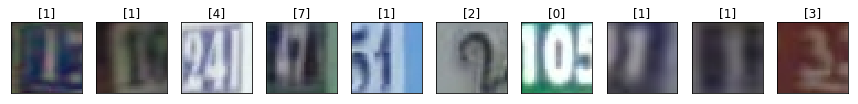

In [9]:
import random
display_random_images(train_data, train_labels)

In [10]:
train_data = np.mean(train_data, axis = 3)
train_data = train_data[:,:,:,np.newaxis]
test_data = np.mean(test_data, axis = 3)
test_data = test_data[:,:,:,np.newaxis]
print(train_data.shape)
print(test_data.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


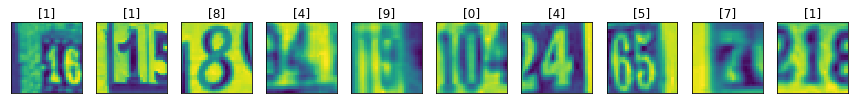

In [11]:
display_random_images(np.squeeze(train_data), train_labels)

In [12]:
def get_MLP_model():
    
    model = Sequential([Flatten(input_shape = (32, 32, 1)),
                       Dense(512, activation = 'relu'),
                       Dense(256, activation = 'relu'),
                       Dense(128, activation = 'relu'),
                       Dense(64, activation = 'relu'),
                       Dense(10, activation = 'softmax')])
    
    model.compile(optimizer = 'adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [13]:
model = get_MLP_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 697,930
Trainable params: 697,930
Non-trainable params: 0
__________________________________________________

In [14]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('modelcheckpointsMLP/epoch_{epoch}',
                                               save_weights_only = True,
                                               save_freq = 'epoch',
                                               save_best_only = True,
                                               monitor = 'val_accuracy')

In [16]:
historyMLP = model.fit(train_data,
                      train_labels,
                      validation_split = 0.15,
                      epochs = 30,
                      batch_size = 32,
                      verbose = 2,
                      callbacks = [earlystopping, checkpoint])

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 - 66s - loss: 3.4750 - accuracy: 0.2800 - val_loss: 1.8570 - val_accuracy: 0.3887
Epoch 2/30
62268/62268 - 68s - loss: 1.5043 - accuracy: 0.5094 - val_loss: 1.3300 - val_accuracy: 0.5758
Epoch 3/30
62268/62268 - 68s - loss: 1.3253 - accuracy: 0.5764 - val_loss: 1.2409 - val_accuracy: 0.6033
Epoch 4/30
62268/62268 - 68s - loss: 1.2303 - accuracy: 0.6159 - val_loss: 1.1755 - val_accuracy: 0.6364
Epoch 5/30
62268/62268 - 69s - loss: 1.1644 - accuracy: 0.6379 - val_loss: 1.0804 - val_accuracy: 0.6583
Epoch 6/30
62268/62268 - 66s - loss: 1.0941 - accuracy: 0.6601 - val_loss: 1.1475 - val_accuracy: 0.6414
Epoch 7/30
62268/62268 - 64s - loss: 1.0593 - accuracy: 0.6744 - val_loss: 1.0402 - val_accuracy: 0.6734
Epoch 8/30
62268/62268 - 63s - loss: 1.0098 - accuracy: 0.6885 - val_loss: 1.0906 - val_accuracy: 0.6637
Epoch 9/30
62268/62268 - 66s - loss: 0.9845 - accuracy: 0.6960 - val_loss: 1.1976 - val_accuracy: 0.6298
Epoch

Text(0.5, 0, 'Epochs')

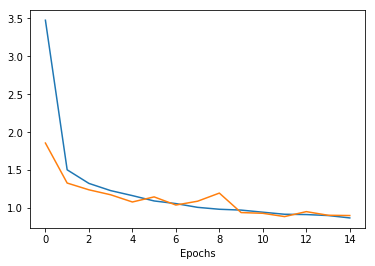

In [17]:
df1 = pd.DataFrame(historyMLP.history)
plt.plot(df1['loss'])
plt.plot(df1['val_loss'])
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

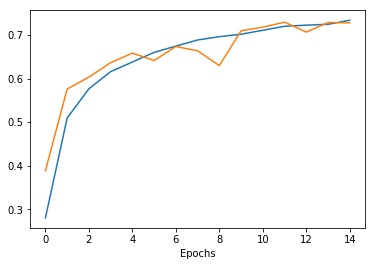

In [18]:
plt.plot(df1['accuracy'])
plt.plot(df1['val_accuracy'])
plt.xlabel('Epochs')

In [19]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose = 0)
print(f'The test loss is: {test_loss}')
print(f'The test accuracy is: {test_accuracy}')

The test loss is: 1.003840840991172
The test accuracy is: 0.7048632502555847


In [20]:
def get_CNN_model():
    
    model = Sequential([Conv2D(8, 3, activation = 'relu', input_shape = (32,32,1)),
                       Dropout(0.3),
                       Conv2D(8, 3, activation = 'relu', padding = 'SAME'),
                       BatchNormalization(),
                       MaxPooling2D(3),
                       Conv2D(16, 3, activation = 'relu'),
                       BatchNormalization(),
                       MaxPooling2D(2),
                       Flatten(), 
                       Dense(64, activation = 'relu'),
                       Dense(10, activation = 'softmax')])
    
    model.compile(optimizer = 'adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [21]:
CNN_model = get_CNN_model()
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         80        
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 16)         

In [22]:
checkpoint1 = tf.keras.callbacks.ModelCheckpoint('modelcheckpointsCNN/epoch_{epoch}',
                                                save_weights_only = True,
                                                save_freq = 'epoch',
                                                save_best_only = True,
                                                monitor = 'val_accuracy')

In [23]:
historyCNN = CNN_model.fit(train_data,
                      train_labels,
                      validation_split = 0.15,
                      epochs = 30,
                      batch_size = 32,
                      verbose = 2,
                      callbacks = [earlystopping, checkpoint1])

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 - 302s - loss: 1.1381 - accuracy: 0.6259 - val_loss: 0.6032 - val_accuracy: 0.8213
Epoch 2/30
62268/62268 - 302s - loss: 0.5521 - accuracy: 0.8307 - val_loss: 0.4618 - val_accuracy: 0.8630
Epoch 3/30
62268/62268 - 312s - loss: 0.4599 - accuracy: 0.8595 - val_loss: 0.4840 - val_accuracy: 0.8551
Epoch 4/30
62268/62268 - 306s - loss: 0.4110 - accuracy: 0.8747 - val_loss: 0.4272 - val_accuracy: 0.8709
Epoch 5/30
62268/62268 - 304s - loss: 0.3815 - accuracy: 0.8835 - val_loss: 0.3933 - val_accuracy: 0.8802
Epoch 6/30
62268/62268 - 308s - loss: 0.3631 - accuracy: 0.8889 - val_loss: 0.4013 - val_accuracy: 0.8777
Epoch 7/30
62268/62268 - 301s - loss: 0.3458 - accuracy: 0.8949 - val_loss: 0.3735 - val_accuracy: 0.8919
Epoch 8/30
62268/62268 - 301s - loss: 0.3318 - accuracy: 0.9000 - val_loss: 0.3645 - val_accuracy: 0.8937
Epoch 9/30
62268/62268 - 303s - loss: 0.3194 - accuracy: 0.9027 - val_loss: 0.3687 - val_accuracy: 0.8

Text(0.5, 0, 'Epochs')

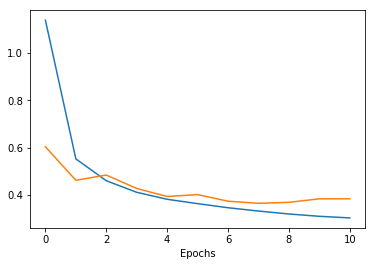

In [24]:
df2 = pd.DataFrame(historyCNN.history)
plt.plot(df2['loss'])
plt.plot(df2['val_loss'])
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

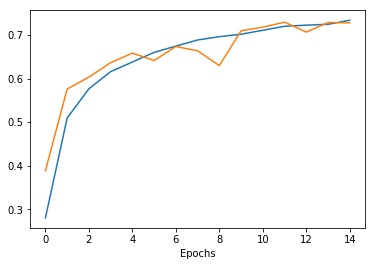

In [25]:
plt.plot(df1['accuracy'])
plt.plot(df1['val_accuracy'])
plt.xlabel('Epochs')

In [26]:
test_loss1, test_accuracy1 = CNN_model.evaluate(test_data, test_labels, verbose = 0)
print(f'The test loss is: {test_loss1}')
print(f'The test accuracy is: {test_accuracy1}')

The test loss is: 0.42272308374942263
The test accuracy is: 0.8756914734840393


In [27]:
filename_MLP = tf.train.latest_checkpoint('modelcheckpointsMLP')
filename_CNN = tf.train.latest_checkpoint('modelcheckpointsCNN')

In [28]:
new_MLP_model = get_MLP_model()
new_CNN_model = get_CNN_model()

In [29]:
new_MLP_model.load_weights(filename_MLP)
new_CNN_model.load_weights(filename_CNN)

In [47]:
pred_MLP = new_MLP_model.predict(test_data)
pred_CNN = new_CNN_model.predict(test_data)

In [48]:
def display_random_images_pred(data, labels, pred_MLP, pred_CNN):
    
    random_list = []
    
    for i in range(5):
        random_list.append(random.randint(0, data.shape[0]))
        
    fig, axes = plt.subplots(3, 5, squeeze = False, figsize = (20, 20))
    
    for i in range(len(random_list)):
        axes[0][i].imshow(data[random_list[i]])
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])
        axes[0][i].title.set_text(str(labels[random_list[i]]))
        axes[1][i].bar(list(range(10)), pred_MLP[random_list[i]])
        axes[1][i].title.set_text('MLP Prediction')
        axes[2][i].bar(list(range(10)), pred_CNN[random_list[i]])
        axes[2][i].title.set_text('CNN Prediction')

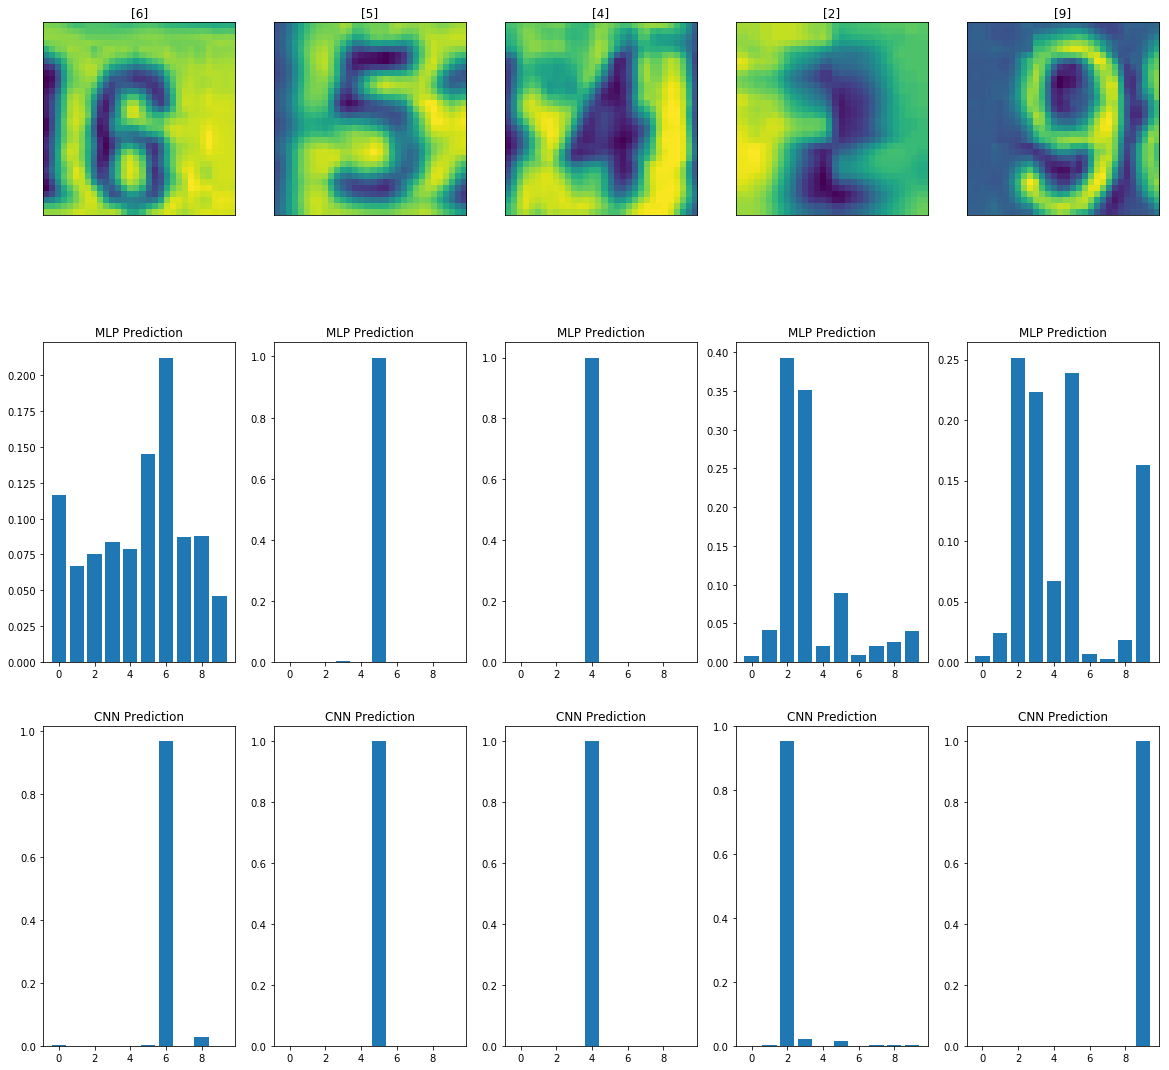

In [49]:
display_random_images_pred(np.squeeze(test_data), test_labels, pred_MLP, pred_CNN)